# 고찰

1. 좋아요 수의 평균을 이용하는 건 위험하다
    - 커뮤니티마다 좋아요를 누르는 성향이 너무 극단적으로 다를 듯
    - 좋아요 수의 합은 의미가 있을 것이다
2. 조회수와 좋아요의 지수 감쇄의 가중값은 다르게 해야한다.
    - 조회수는 0.05에서 충분히 활발한 움직임을 보인다.
    - 좋아요는 0.02에서 충분히 활발한 움직임을 보인다.
3. 좋은 피처
    - `movingAverage(0.05, mean(community_normalized(log(View))))`
    - `movingAverage(0.02, sum(community_normalized(log(Like))))`

In [24]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. 데이터 로드 및 이슈 선택

In [25]:
with open('../data/defect_data.json', 'r', encoding='utf-8') as f:
    defect_data = json.load(f)

print("아래 이슈 중 인덱스를 하나 선택하세요")

dfs = []
for i,defect in enumerate(defect_data):
    car_name = defect['car_name']
    defect_type = defect['defect_type']

    df = pd.read_csv(f"../data/defect/{car_name}_{defect_type}_adft.csv") # adft = additional features
    df['Date'] = pd.to_datetime(df['Date'])
    dfs.append(df)

    print(i, car_name, defect_type, df.shape)

아래 이슈 중 인덱스를 하나 선택하세요
0 그랜저 제동 (967, 14)
1 그랜저 단차 (926, 14)
2 그랜저 시동 (1640, 14)
3 팰리세이드 안전벨트 (435, 14)
4 팰리세이드 시동 (1986, 14)
5 아이오닉 누수 (2125, 14)
6 아이오닉 방전 (4160, 14)
7 아이오닉 ICCU (8035, 14)
8 아반떼 전방센서 (926, 14)
9 제네시스 누유 (1359, 14)
10 제네시스 급발진 (271, 14)
11 캐스퍼 누수 (1533, 14)
12 캐스퍼 가속 (411, 14)
13 캐스퍼 떨림 (1158, 14)


In [26]:
ISSUE_INDEX = 6

df = dfs[ISSUE_INDEX]
print("선택한 이슈:")

car_name = defect_data[ISSUE_INDEX]['car_name']
defect_type = defect_data[ISSUE_INDEX]['defect_type']
keywords = defect_data[ISSUE_INDEX]['keywords']
news_dates = defect_data[ISSUE_INDEX]['news_dates']

car_name, defect_type, news_dates

선택한 이슈:


('아이오닉', '방전', ['2023-03-31', '2023-06-18'])

### 날짜 별 해당 이슈의 게시글 개수

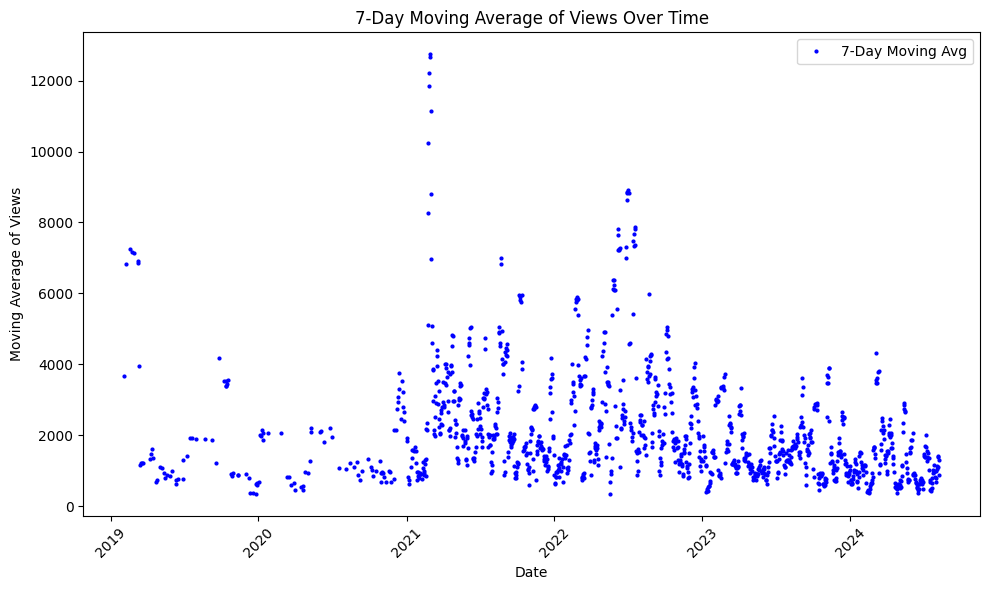

In [27]:
grouped = df.groupby('Date')['View'].sum().reset_index()

# 이동 평균 계산 (예: 7일 이동 평균)
grouped['Moving_Avg_View'] = grouped['View'].rolling(window=7).mean()

# 이동 평균을 플롯
plt.figure(figsize=(10, 6))
plt.plot(grouped['Date'], grouped['Moving_Avg_View'], marker='o', linestyle='None', color='b', label='7-Day Moving Avg', markersize=2)

# 그래프 꾸미기
plt.title('7-Day Moving Average of Views Over Time')
plt.xlabel('Date')
plt.ylabel('Moving Average of Views')
plt.xticks(rotation=45)  # X축의 날짜가 겹치지 않도록 회전
plt.legend()

# 그래프 보여주기
plt.tight_layout()
plt.show()

# 1. 그래프 그리기 함수 정의

### 알림을 주는 트리거 시점

In [28]:
def detect_triggers(grouped, y, window=7, std_threshold=2):
    trigger_dates = []

    # 이동 평균과 이동 표준 편차 계산
    grouped['Moving_Avg'] = grouped[y].rolling(window=window).mean()
    grouped['Moving_Std'] = grouped[y].rolling(window=window).std()

    for i in range(window, len(grouped)):
        current_value = grouped[y].iloc[i]
        moving_avg = grouped['Moving_Avg'].iloc[i]
        moving_std = grouped['Moving_Std'].iloc[i]

        # 현재 값이 이동 평균에서 이동 표준 편차의 일정 배수만큼 벗어날 때 감지
        if abs(current_value - moving_avg) > std_threshold * moving_std:
            trigger_dates.append(grouped['Date'].iloc[i])

    return trigger_dates

### 1.1. 단일 특성

In [29]:
def plot_column_over_time(grouped, y, news_dates=news_dates, window=7, alert_threshold=2.1):
    plt.figure(figsize=(10, 6))
    
    # 데이터 플롯
    plt.plot(grouped['Date'], grouped[y], marker='o', linestyle='None', color='b', label=y, markersize=1)

    # 뉴스 데이터
    for news_date in news_dates:
        plt.axvline(pd.to_datetime(news_date), color='r', linestyle='--', linewidth=1, label='News')

    # 급진적인 증가가 발생한 시점을 감지
    trigger_dates = detect_triggers(grouped, y, window, alert_threshold)
    for trigger_date in trigger_dates:
        plt.axvline(pd.to_datetime(trigger_date), color='g', linestyle='--', linewidth=1)

    plt.title(f'[{y}] Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

### 1.2. 두개 특성 비교

In [30]:
def plot_two_columns_over_time(grouped, y1_column, y2_column, news_dates=news_dates):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 첫 번째 Y축
    ax1.set_xlabel('Date')
    ax1.set_ylabel(y1_column, color='b')
    ax1.plot(grouped['Date'], grouped[y1_column], marker='o', linestyle='None', color='b', label=y1_column, markersize=1)
    ax1.tick_params(axis='y', labelcolor='b')

    # 두 번째 Y축
    ax2 = ax1.twinx()  # x축을 공유하는 두 번째 y축 생성
    ax2.set_ylabel(y2_column, color='r')
    ax2.plot(grouped['Date'], grouped[y2_column], marker='x', linestyle='None', color='r', label=y2_column, markersize=1)
    ax2.tick_params(axis='y', labelcolor='r')

    for news_date in news_dates:
        news_date = pd.to_datetime(news_date)
        ax1.axvline(news_date, color='g', linestyle='--', linewidth=1)

    # 그래프 꾸미기
    plt.title(f'[{y1_column}] and [{y2_column}] Over Time')
    fig.tight_layout()  # 그래프 요소들이 겹치지 않도록 조정
    plt.xticks(rotation=45)

    plt.show()

# 2. 날짜별 데이터를 그룹화

In [31]:
df['Log_View'] = df['View']
df['Log_Like'] = df['Like']

grouped = df.groupby('Date').agg({
    'View': ['sum', 'mean'],
    'Like': ['sum', 'mean'],
    'Log_View': ['sum', 'mean'],
    'Log_Like': ['sum', 'mean'],
    'Normalized_View': ['sum', 'mean'],
    'Normalized_Like': ['sum', 'mean'],
    'Normalized_Log_View': ['sum', 'mean'],
    'Normalized_Log_Like': ['sum', 'mean'],
}).reset_index()

# 컬럼 이름 정리
grouped.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped.columns.values]

grouped.head()

,Date,View_sum,View_mean,Like_sum,Like_mean,Log_View_sum,Log_View_mean,Log_Like_sum,Log_Like_mean,Normalized_View_sum,Normalized_View_mean,Normalized_Like_sum,Normalized_Like_mean,Normalized_Log_View_sum,Normalized_Log_View_mean,Normalized_Log_Like_sum,Normalized_Log_Like_mean
0,2019-01-02,267,267.0,0,0.0,267,267.0,0,0.0,0.001859,0.001859,0.000000,0.000000,0.359456,0.359456,0.000000,0.000000
1,2019-01-04,1276,1276.0,2,2.0,1276,1276.0,2,2.0,0.009073,0.009073,0.000872,0.000872,0.519275,0.519275,0.141967,0.141967
2,2019-01-07,1007,1007.0,0,0.0,1007,1007.0,0,0.0,0.007150,0.007150,0.000000,0.000000,0.495062,0.495062,0.000000,0.000000
3,2019-01-16,344,172.0,1,0.5,344,172.0,1,0.5,0.014121,0.007061,0.003086,0.001543,0.625550,0.312775,0.119842,0.059921
4,2019-01-17,1919,959.5,5,2.5,1919,959.5,5,2.5,0.013620,0.006810,0.002180,0.001090,0.962363,0.481182,0.321110,0.160555


In [32]:
start_date = df['Date'].min()
end_date = df['Date'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
grouped.set_index('Date', inplace=True)
grouped = grouped.reindex(all_dates).fillna(0)
grouped = grouped.reset_index().rename(columns={'index': 'Date'})

### 지수감쇄 이동평균 계산식을 통한 새로운 열 만들기

In [33]:
moving_avg_prefix = 'Moving_Avg'

def apply_moving_average(grouped, column_name):
    new_column_name = f'{moving_avg_prefix}_{column_name}'
    grouped[new_column_name] = 0.0

    # 초기 값 설정
    grouped.loc[0, new_column_name] = grouped.loc[0, column_name]

    # 이동 계산식 적용
    alpha = 0.05
    for i in range(1, len(grouped)):
        grouped.loc[i, new_column_name] = (
            (1-alpha) * grouped.loc[i-1, new_column_name] + alpha * grouped.loc[i, column_name]
        )

    return grouped

for column in grouped.columns:
    if column.startswith(moving_avg_prefix):
        continue
    if pd.api.types.is_numeric_dtype(grouped[column]):
        grouped = apply_moving_average(grouped, column)

grouped.head()

,Date,View_sum,View_mean,Like_sum,Like_mean,Log_View_sum,Log_View_mean,Log_Like_sum,Log_Like_mean,Normalized_View_sum,...,Moving_Avg_Log_Like_sum,Moving_Avg_Log_Like_mean,Moving_Avg_Normalized_View_sum,Moving_Avg_Normalized_View_mean,Moving_Avg_Normalized_Like_sum,Moving_Avg_Normalized_Like_mean,Moving_Avg_Normalized_Log_View_sum,Moving_Avg_Normalized_Log_View_mean,Moving_Avg_Normalized_Log_Like_sum,Moving_Avg_Normalized_Log_Like_mean
0,2019-01-02,267.0,267.0,0.0,0.0,267.0,267.0,0.0,0.0,0.001859,...,0.00000,0.00000,0.001859,0.001859,0.000000,0.000000,0.359456,0.359456,0.000000,0.000000
1,2019-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.00000,0.001766,0.001766,0.000000,0.000000,0.341483,0.341483,0.000000,0.000000
2,2019-01-04,1276.0,1276.0,2.0,2.0,1276.0,1276.0,2.0,2.0,0.009073,...,0.10000,0.10000,0.002131,0.002131,0.000044,0.000044,0.350373,0.350373,0.007098,0.007098
3,2019-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.09500,0.09500,0.002025,0.002025,0.000041,0.000041,0.332854,0.332854,0.006743,0.006743
4,2019-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.09025,0.09025,0.001924,0.001924,0.000039,0.000039,0.316212,0.316212,0.006406,0.006406


# 3. 특성 별 경향 분석

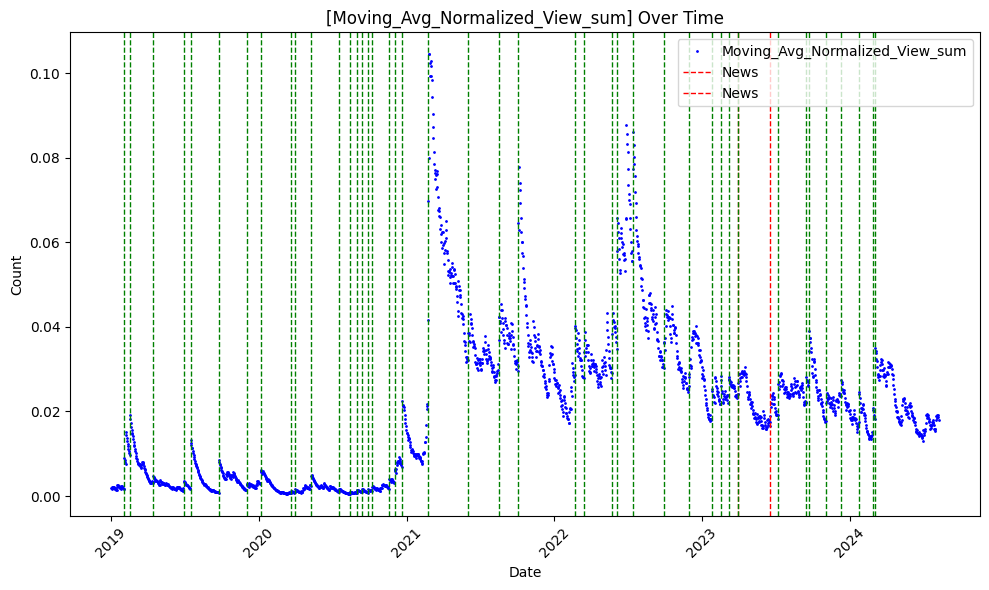

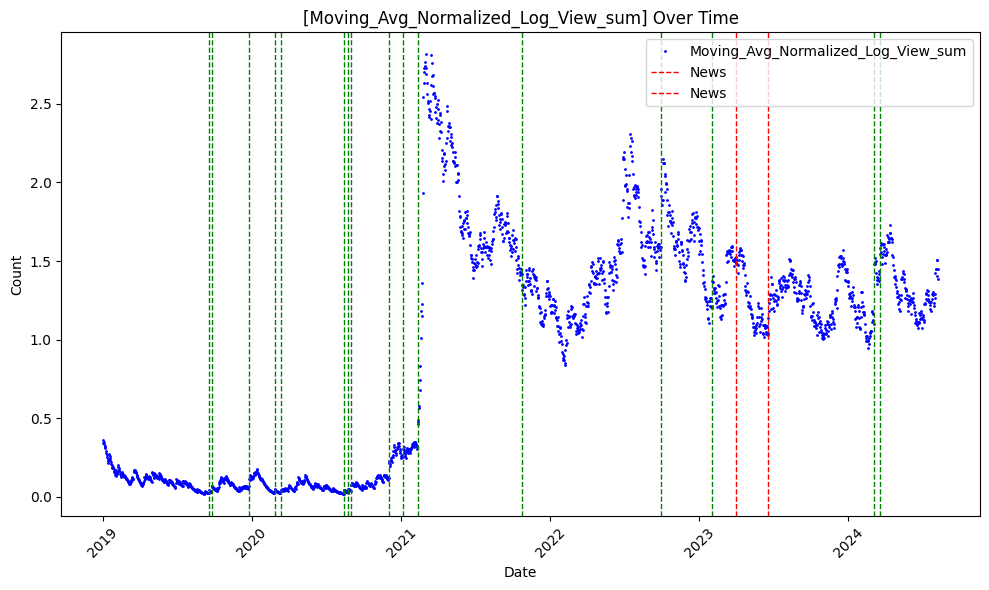

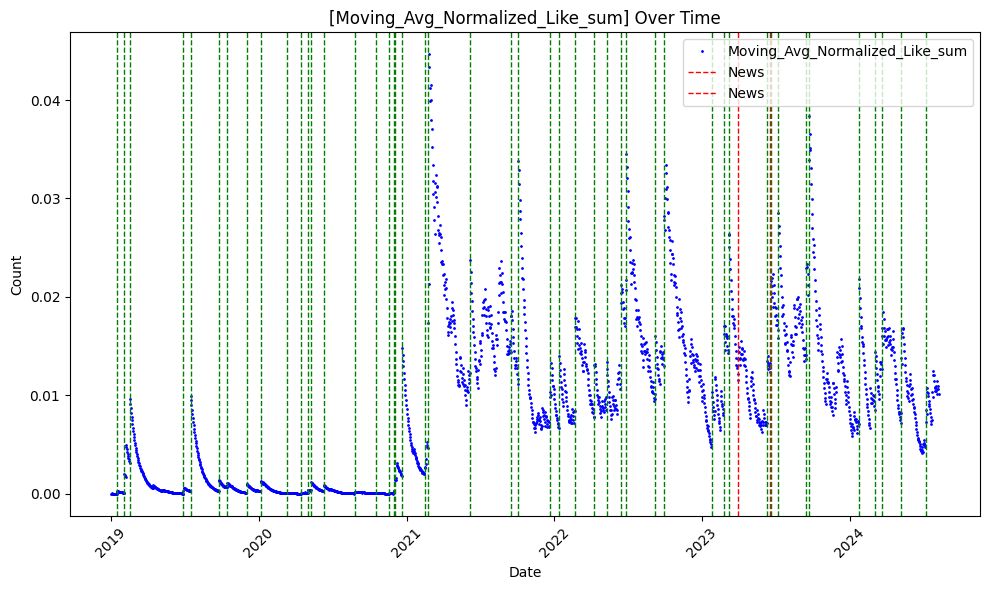

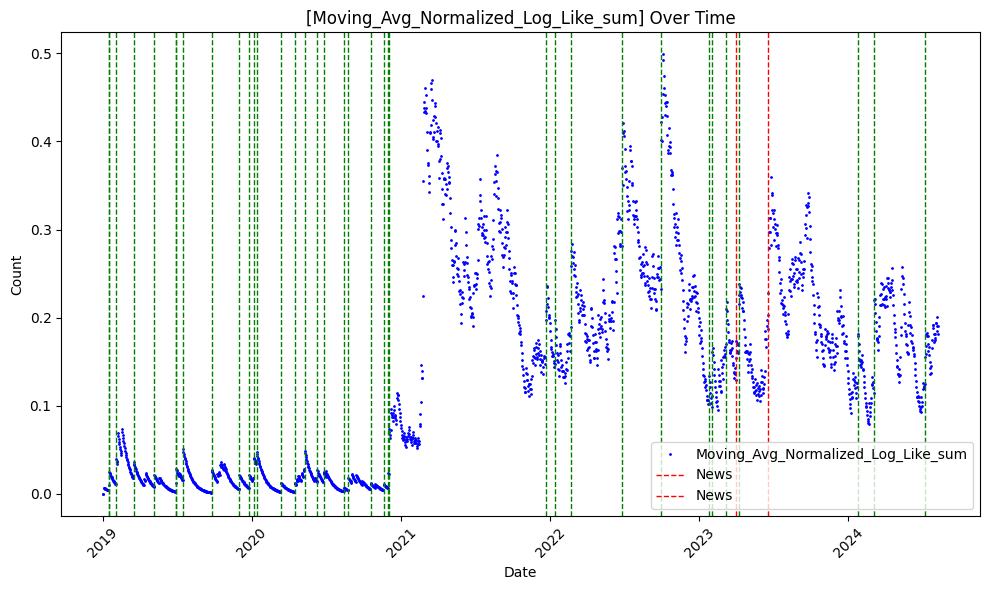

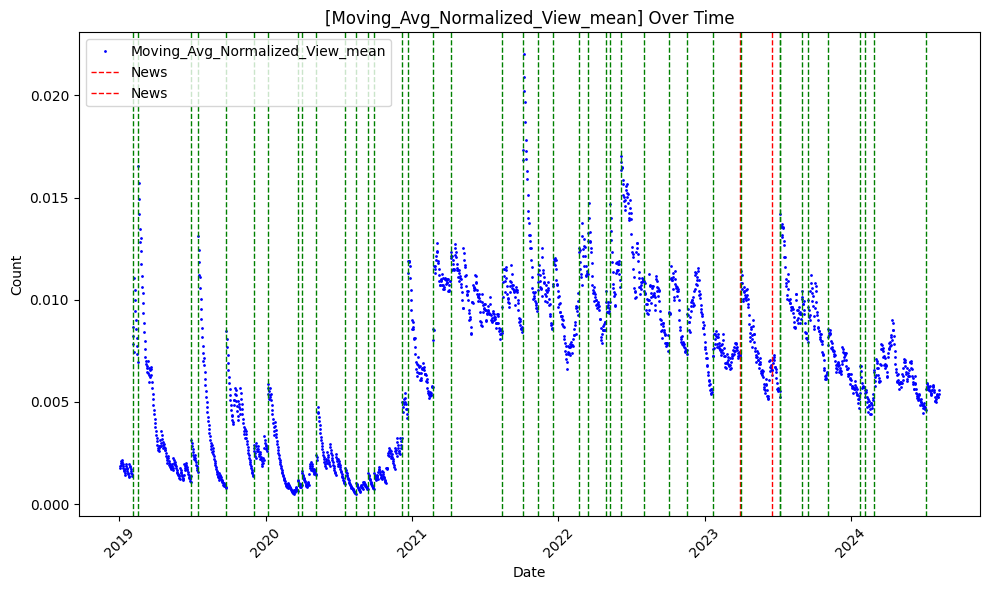

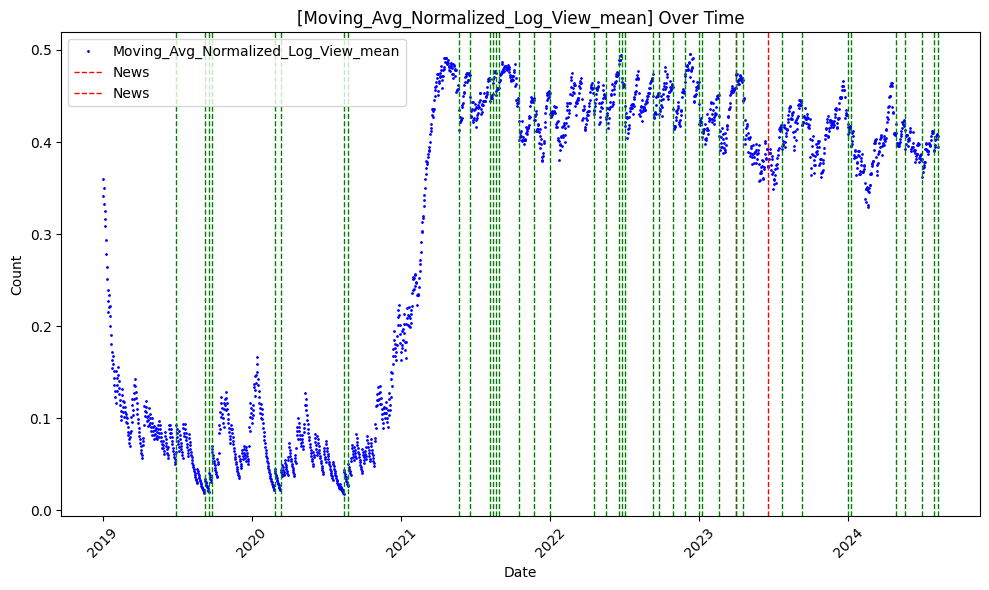

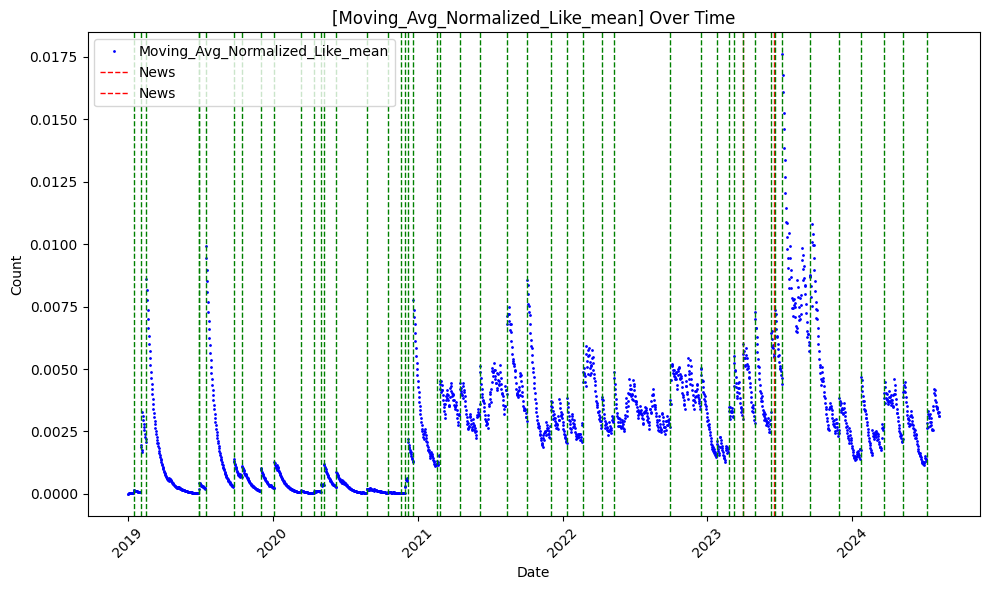

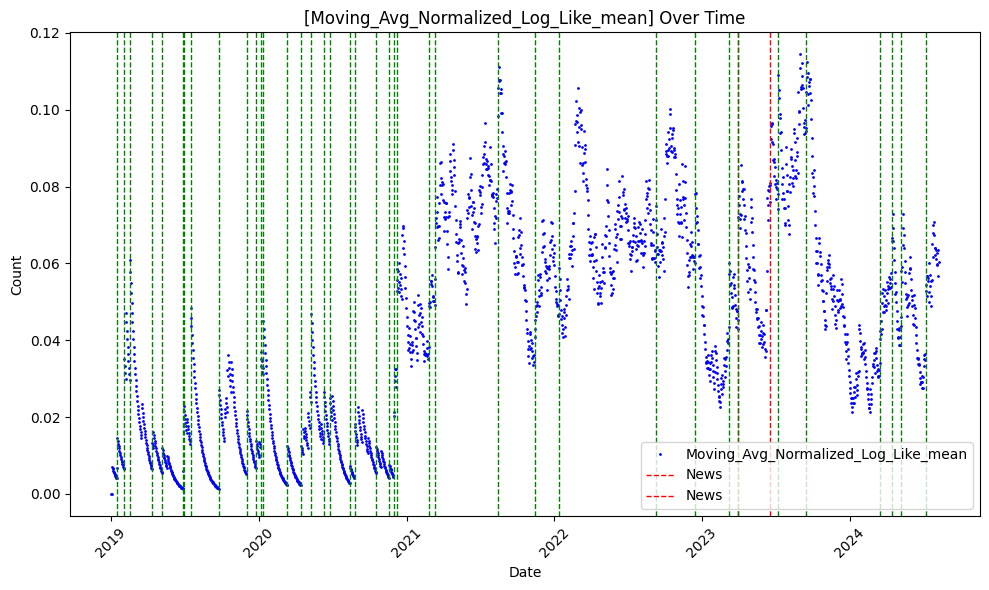

In [34]:
plot_column_over_time(grouped, 'Moving_Avg_Normalized_View_sum')
plot_column_over_time(grouped, 'Moving_Avg_Normalized_Log_View_sum')
plot_column_over_time(grouped, 'Moving_Avg_Normalized_Like_sum')
plot_column_over_time(grouped, 'Moving_Avg_Normalized_Log_Like_sum')
plot_column_over_time(grouped, 'Moving_Avg_Normalized_View_mean')
plot_column_over_time(grouped, 'Moving_Avg_Normalized_Log_View_mean')
plot_column_over_time(grouped, 'Moving_Avg_Normalized_Like_mean')
plot_column_over_time(grouped, 'Moving_Avg_Normalized_Log_Like_mean')

# 4. 추가 피처 만들기

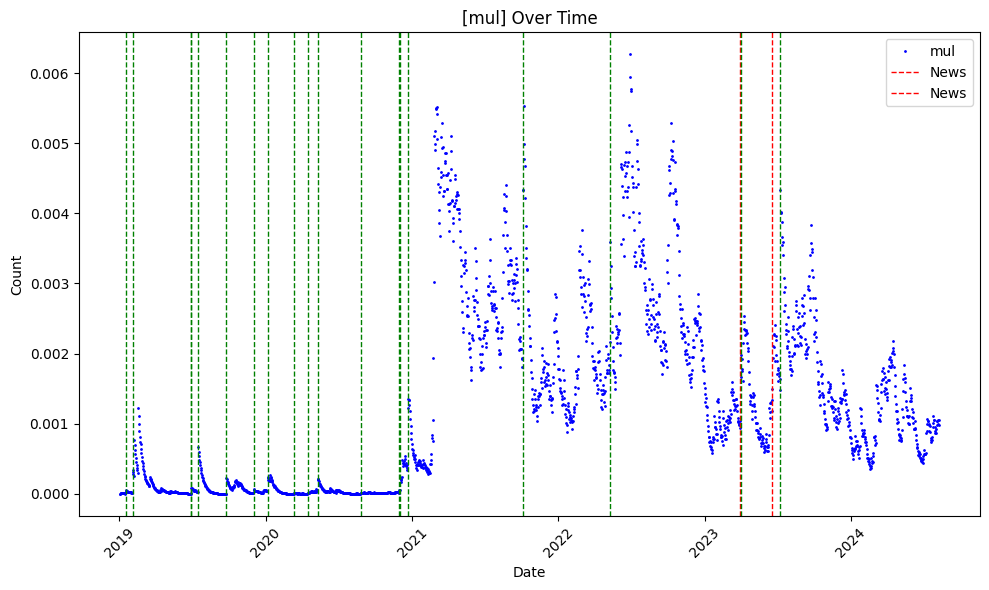

In [35]:
mul_features = [
    # 'Moving_Avg_Normalized_Log_View_sum',
    'Moving_Avg_Normalized_Log_Like_sum',
    'Moving_Avg_Normalized_View_mean',
    # 'Moving_Avg_Normalized_Log_View_mean',
    # 'Moving_Avg_Normalized_Log_Like_mean'
]

grouped['mul'] = 1
for feature in mul_features:
    grouped['mul'] *= grouped[feature]

plot_column_over_time(grouped, 'mul', window=10, alert_threshold=2.7)

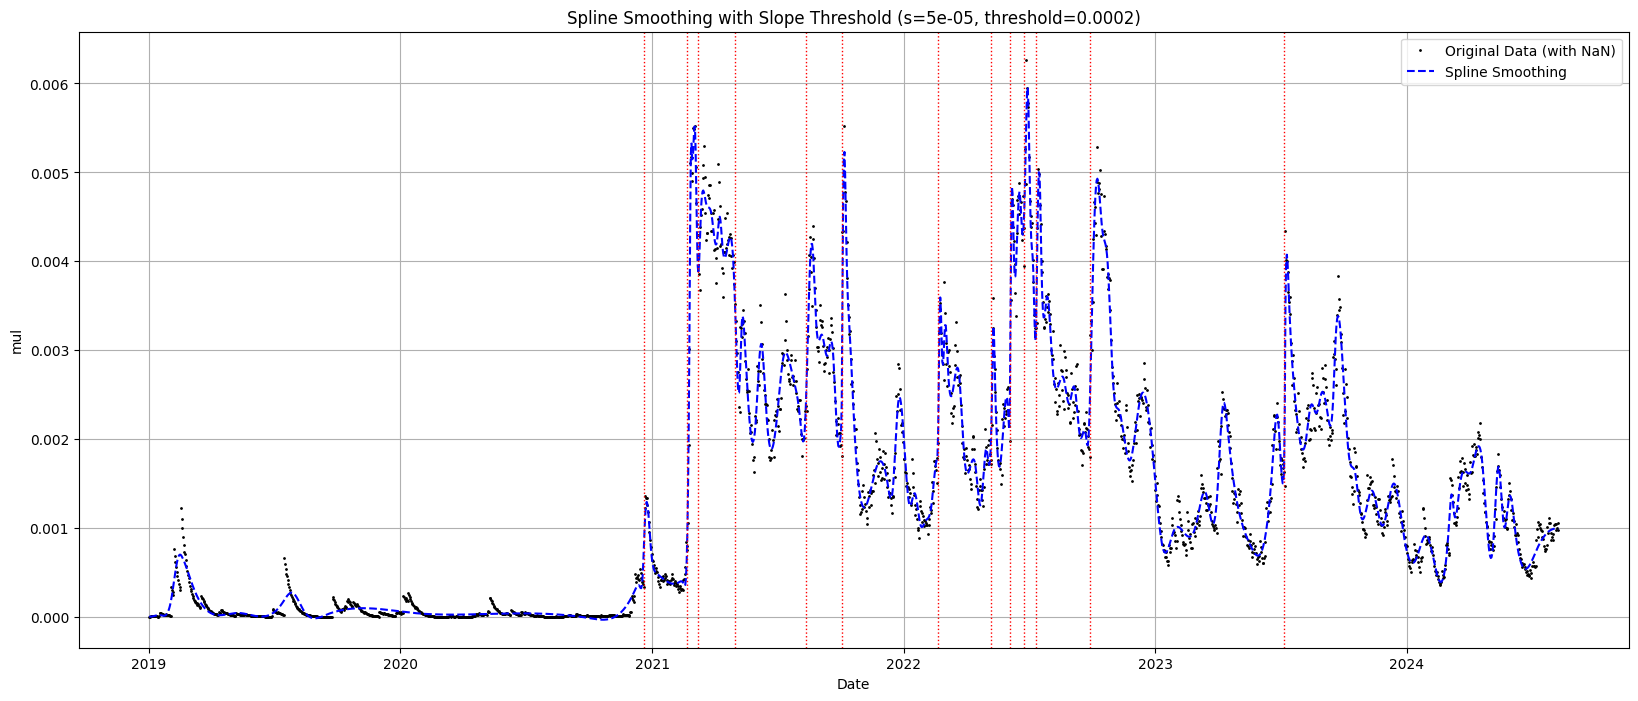

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def plot_spline_smoothing_with_threshold(df, y_column_name, s, slope_threshold, min_days_between_lines=15):
    """
    주어진 데이터프레임(df)에서 특정 열(y_column_name)을 스플라인 스무딩하여 결과를 시각화하고,
    스무딩된 곡선의 기울기가 특정 임계값(slope_threshold)을 초과하는 지점에 세로선을 그리는 함수.
    
    Parameters:
    df (pd.DataFrame): 시계열 데이터프레임
    y_column_name (str): 스플라인 스무딩할 열의 이름
    s (float): 스플라인 스무딩 강도를 조절하는 파라미터
    slope_threshold (float): 기울기의 임계값
    """
    # 결측치 제거한 데이터로 스플라인 스무딩
    valid = df.dropna(subset=[y_column_name])
    X = np.array(valid.index).reshape(-1, 1)
    y = valid[y_column_name].values

    spline = UnivariateSpline(valid.index, valid[y_column_name], s=s)  # 스무딩 적용
    df['Spline_Smoothed'] = spline(df.index)

    # 스무딩된 곡선의 기울기 계산
    df['Slope'] = np.gradient(df['Spline_Smoothed'], df.index)

    # 결과 시각화
    plt.figure(figsize=(20, 8))

    # 원래 데이터
    plt.plot(df['Date'], df[y_column_name], 'o', label='Original Data (with NaN)', color='black', markersize=1)

    # 스플라인 스무딩
    plt.plot(df['Date'], df['Spline_Smoothed'], label='Spline Smoothing', linestyle='--', color='blue')

    # 기울기가 임계값을 초과하는 지점에 세로선 그리기
    # threshold_crossed = False
    # for i in range(1, len(df)):
    #     if df['Slope'].iloc[i] > slope_threshold and not threshold_crossed:
    #         plt.axvline(x=df['Date'].iloc[i], color='red', linestyle=':', linewidth=1)
    #         threshold_crossed = True
    #     elif df['Slope'].iloc[i] <= slope_threshold:
    #         threshold_crossed = False
    # 기울기가 임계값을 초과하는 지점에 세로선 그리기
    last_line_date = None
    for i in range(1, len(df)):
        if abs(df['Slope'].iloc[i]) > slope_threshold:
            current_date = df['Date'].iloc[i]
            if last_line_date is None or (current_date - last_line_date).days > min_days_between_lines:
                plt.axvline(x=current_date, color='red', linestyle=':', linewidth=1)
                last_line_date = current_date

    plt.xlabel('Date')
    plt.ylabel(y_column_name)
    plt.title(f'Spline Smoothing with Slope Threshold (s={s}, threshold={slope_threshold})')
    plt.legend()
    plt.grid(True)
    plt.show()

# 함수 사용 예시
plot_spline_smoothing_with_threshold(grouped, 'mul', s=0.00005, slope_threshold=0.0002)